In [1]:
%run style_and_packages.ipynb

# Beispiel: Antwortspektrenverfahren an einem zweistöckigen Gebäude


## Aufgabenstellung

![Statisches System des zweistöckigen Gebäudes](bilder/zweistoeckig_objekt.jpg){#fig-zweistock}

![Antwortspektren nach SIA261:2020](bilder/antwortspektren_norm.jpg){#fig-antwortspektren}

Gesucht:

- Eigenfrequenzen $\omega_n$ 
- Darstellung der Eigenformen
- Modal- und Spektralmatrix
- Maximale Gesamtverformung mittels SRSS-Kombinationsregel aus dem Antwortspektrum der Pseudobeschleunigung (Kurve E in @fig-antwortspektren)
- Resultierende Schnittgrössen

Gegeben:

- Biegesteifigkeit Stützen $EI_{(a-c)} = 1.2 \cdot 10^6 \text{Nmm}^2$
- Biegesteifigkeit Stützen $EI_{(d)} = 1.0 \cdot 10^6 \text{Nmm}^2$
- Massen $m_1 = 2.1 \text{t}$ und $m_2 = 4.8 \text{t}$
- Stockwerkshöhen $H_1 = 3.81\text{m}$ und $H_2 = 3 \text{m}$


Korrekte Angaben zur Ermittlung des Antwortspektrums


{{< pagebreak >}}
## Musterlösung


In [2]:
#| label: tbl-parameter_mms6
#| tbl-cap: Verwendete Parameter

params = {'EI_ac': 5.5*10**5 *unit.N*unit.m**2,
'EI_d': 2.5*10**5 *unit.N*unit.m**2,
          'm_1':2100*unit.N*unit.second**2/unit.m,
          'm_2':4800*unit.N*unit.second**2/unit.m,
          'H_1':3.81*unit.m,
          'H_2':3*unit.m,
          }

params_plot = convert.param_value(params)
render.dict_to_table(params)

| Parameter |  |
|---|---|
| $EI_{ac} = 550000.0 \text{m}^{2} \text{N}$ | $EI_{d} = 250000.0 \text{m}^{2} \text{N}$ |
| $H_{1} = 3.81 \text{m}$ | $H_{2} = 3 \text{m}$ |
| $m_{1} = \frac{2100 \text{N} \text{s}^{2}}{\text{m}}$ | $m_{2} = \frac{4800 \text{N} \text{s}^{2}}{\text{m}}$ |



![Modellierung als Zweimassenschwinger](bilder/mms_6_modell.png){#fig-modell_mms6}

### Massenmatrix $M$

In [3]:
m_1, m_2 = sp.symbols('m_1, m_2')

In [4]:
M = sp.Matrix([[m_1,0],[0,m_2]])

render.eq_display(sp.MatrixSymbol('M', 2, 2), M,
                  sp.MatrixSymbol('M', 2, 2), M.subs(params))

    ⎡m₁  0 ⎤
M = ⎢      ⎥
    ⎣0   m₂⎦

    ⎡                  2                     ⎤
    ⎢2100⋅newton⋅second                      ⎥
    ⎢───────────────────           0         ⎥
    ⎢       meter                            ⎥
M = ⎢                                        ⎥
    ⎢                                       2⎥
    ⎢                     4800⋅newton⋅second ⎥
    ⎢         0           ───────────────────⎥
    ⎣                            meter       ⎦

### Steifigkeitsmatrix $K$

#### Steifigkeit der Stockwerke
Die Steifigkeit des Systems in @fig-modell_mms6 entspricht der Geschosssteifigkeit. Dazu sind die Steifigkeiten der Stützen zu addieren.

In [5]:
EI_ac, EI_d, H_1, H_2 = sp.symbols("EI_ac, EI_d, H_1, H_2")


In [6]:
k_1 = 12 * EI_ac /H_1**3 * 2
k_2 = 12*EI_ac / H_2**3 + 12*EI_d / H_2**3

render.eq_display("k_1", k_1,
'k_1', k_1.subs(params).simplify().evalf(3),
"k_2", k_2,
'k_2', k_2.subs(params).simplify().evalf(3))

     24⋅EI_ac
k₁ = ────────
         3   
       H₁    

     2.39e+5⋅newton
k₁ = ──────────────
         meter     

     12⋅EI_ac   12⋅EI_d
k₂ = ──────── + ───────
         3          3  
       H₂         H₂   

     3.56e+5⋅newton
k₂ = ──────────────
         meter     

Abgefüllt in die Steifigkeitsmatrix

In [7]:
K = sp.Matrix([[k_1 + k_2, -k_2],[-k_2, k_2]])

render.eq_display(sp.MatrixSymbol('K', 2, 2), "Matrix([[k_1 + k_2, -k_2],[-k_2, k_2]])",
sp.MatrixSymbol('K', 2, 2), K,
                  sp.MatrixSymbol('K', 2, 2), K.subs(params).evalf(3))

    ⎡k₁ + k₂  -k₂⎤
K = ⎢            ⎥
    ⎣  -k₂    k₂ ⎦

    ⎡12⋅EI_ac   24⋅EI_ac   12⋅EI_d    12⋅EI_ac   12⋅EI_d⎤
    ⎢──────── + ──────── + ───────  - ──────── - ───────⎥
    ⎢    3          3          3          3          3  ⎥
    ⎢  H₂         H₁         H₂         H₂         H₂   ⎥
K = ⎢                                                   ⎥
    ⎢      12⋅EI_ac   12⋅EI_d        12⋅EI_ac   12⋅EI_d ⎥
    ⎢    - ──────── - ───────        ──────── + ─────── ⎥
    ⎢          3          3              3          3   ⎥
    ⎣        H₂         H₂             H₂         H₂    ⎦

    ⎡ 5.94e+5⋅newton   -3.56e+5⋅newton ⎤
    ⎢ ──────────────   ────────────────⎥
    ⎢     meter             meter      ⎥
K = ⎢                                  ⎥
    ⎢-3.56e+5⋅newton    3.56e+5⋅newton ⎥
    ⎢────────────────   ────────────── ⎥
    ⎣     meter             meter      ⎦

### Eigenvektoren 

#### Eigenkreisfrequenzen 
Bei einem Mehrmassenschwinger gibt es entsprechend den Freiheitsgraden Eigenkreisfrequenzen $\omega_n$. Diese lassen sich anhand folgender Gleichung bestimmen:

$$\det{[\mathbf{K}-\omega_n^2 \mathbf{M}]=0}$$

In [8]:
omega_n =sp.symbols('omega_n')
eq_omega = sp.det(K-omega_n**2*M)

omega_n_solve = sp.solve(eq_omega, omega_n)
omega_1 = omega_n_solve[1]
omega_2 = omega_n_solve[3]

render.eq_display('omega_1', omega_1.subs(params).simplify().evalf(3),
                  'omega_2', omega_2.subs(params).simplify().evalf(3))

      5.04 
ω₁ = ──────
     second

      18.2 
ω₂ = ──────
     second

#### Eigenvektoren $\phi$
Durch das Einsetzen der bestimmten Eigenkreisfrequenzen lassen sich die Eigenvektoren bestimmen. 
Beide Einträge des Eigenvektors sind voneinander abhängig und lassen sich dem entsprechen beliebig definieren. Grundsätzlich wird der maximale Eigenwert zu $1$ gesetzt.

$$\mathbf{K} - \omega_n^2 \mathbf{M} \phi_n= 0$$

In [9]:
phi_11, phi_21 = sp.symbols('phi_11, phi_21')
params['phi_11'] = 1 


phi_1 = sp.Matrix([[phi_11], [phi_21]])
phi_21 = list(sp.solve((K-omega_1**2 *M)*phi_1, phi_21).values())[0]


params['phi_21'] = phi_21.subs(params).simplify() 
params['phi_11'] = 1/phi_21.subs(params).simplify() 
params['phi_21'] = 1


render.eq_display(sp.MatrixSymbol('phi_1', 2,1),sp.simplify(phi_1.subs(params)).evalf(3))

     ⎡0.657⎤
φ₁ = ⎢     ⎥
     ⎣ 1.0 ⎦

In [10]:
phi_12, phi_22 = sp.symbols('phi_12, phi_22')
params['phi_12'] = 1

phi_2 = sp.Matrix([[phi_12], [phi_22]])

phi_22 = list(sp.solve((K-omega_2**2 *M)*phi_2, phi_22).values())[0]

params['phi_22'] = phi_22.subs(params).simplify() 




render.eq_display(sp.MatrixSymbol('phi_2', 2,1),sp.simplify(phi_2.subs(params)).evalf(3))

     ⎡ 1.0  ⎤
φ₂ = ⎢      ⎥
     ⎣-0.288⎦

#### Darstellung der Eigenvektoren 

Die Darstellung der Eigenvektoren besteht aus der Biegedeformation mit den Eigenvektoren entsprechenden Kopfauslenkungen. Für den Fall einer beidseitigen Einspannung und einer Verschiebung an den Knoten, entspricht die Deformation der @eq-deformation_geloest.

$$
w(x) = \Delta_A + (\Delta_B- \Delta_A)(3\xi^2 - 2 \xi^3)
$${#eq-deformation_geloest}

mit 
$$
\xi = \frac{x}{l}
$$

wobei $x$ die Laufvariable ist und $l$ die Stablänge, oder in diesem Fall die Stockwerkshöhe.

Für den ersten Eigenvektor

In [11]:
Delta_A, Delta_B, zeta = sp.symbols('Delta_A, Delta_B, zeta')



#Ansatzfunktion für Teil 1 der Funktion
zeta = x/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)
render.eq_display('w(x)', w_ansatz)

w_1_x = w_ansatz.subs(Delta_A, 0).subs(Delta_B, phi_11.subs(params)).subs(l,H_1.subs(params_plot))




#Ansatzfunktion für Teil 2 der Funktion
zeta = (x-H_1.subs(params_plot))/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)
render.eq_display('w(x)', w_ansatz.evalf(2))

w_2_x = w_ansatz.subs(Delta_A, phi_11.subs(params)).subs(Delta_B, phi_21.subs(params)).subs(l,H_2.subs(params_plot))



#Zusammengestellt
w_eigenform_1 = sp.Eq(w,sp.Piecewise((w_1_x, x<=H_1.subs(params_plot)),(w_2_x, x>=H_1.subs(params_plot))))
render.eq_display(w_eigenform_1.lhs, w_eigenform_1.rhs.evalf(2))


                          ⎛   2      3⎞
                          ⎜3⋅x    2⋅x ⎟
w(x) = Δ_A + (-Δ_A + Δ_B)⋅⎜──── - ────⎟
                          ⎜  2      3 ⎟
                          ⎝ l      l  ⎠

                          ⎛                   2                        3⎞
                          ⎜44.0⋅(0.26⋅x - 1.0)    1.1e+2⋅(0.26⋅x - 1.0) ⎟
w(x) = Δ_A + (-Δ_A + Δ_B)⋅⎜──────────────────── - ──────────────────────⎟
                          ⎜          2                       3          ⎟
                          ⎝         l                       l           ⎠

    ⎧                        3         2                             
    ⎪               - 0.024⋅x  + 0.14⋅x                  for x ≤ 3.81
w = ⎨                                                                
    ⎪                    3                     2                     
    ⎩- 1.4⋅(0.26⋅x - 1.0)  + 1.7⋅(0.26⋅x - 1.0)  + 0.66  for x ≥ 3.81

Für den zweiten Eigenvektor. (Es bedingt eine Verschiebung der Laufvariable $x$ um die $H_1$)

In [12]:
Delta_A, Delta_B, zeta = sp.symbols('Delta_A, Delta_B, zeta')



#Ansatzfunktion für Teil 1 der Funktion
zeta = x/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)
render.eq_display('w(x)', w_ansatz)

w_12_x = w_ansatz.subs(Delta_A, 0).subs(Delta_B, phi_12.subs(params)).subs(l,H_1.subs(params_plot))




#Ansatzfunktion für Teil 2 der Funktion
zeta = (x-H_1.subs(params_plot))/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)
render.eq_display('w(x)', w_ansatz.evalf(2))

w_22_x = w_ansatz.subs(Delta_A, phi_12.subs(params)).subs(Delta_B, phi_22.subs(params)).subs(l,H_2.subs(params_plot))



#Zusammengestellt
w_eigenform_2 = sp.Eq(w,sp.Piecewise((w_12_x, x<=H_1.subs(params_plot)),(w_22_x, x>=H_1.subs(params_plot))))
render.eq_display(w_eigenform_2.lhs, w_eigenform_2.rhs.evalf(2))


                          ⎛   2      3⎞
                          ⎜3⋅x    2⋅x ⎟
w(x) = Δ_A + (-Δ_A + Δ_B)⋅⎜──── - ────⎟
                          ⎜  2      3 ⎟
                          ⎝ l      l  ⎠

                          ⎛                   2                        3⎞
                          ⎜44.0⋅(0.26⋅x - 1.0)    1.1e+2⋅(0.26⋅x - 1.0) ⎟
w(x) = Δ_A + (-Δ_A + Δ_B)⋅⎜──────────────────── - ──────────────────────⎟
                          ⎜          2                       3          ⎟
                          ⎝         l                       l           ⎠

    ⎧                      3         2                            
    ⎪             - 0.036⋅x  + 0.21⋅x                 for x ≤ 3.81
w = ⎨                                                             
    ⎪                  3                     2                    
    ⎩5.3⋅(0.26⋅x - 1.0)  - 6.2⋅(0.26⋅x - 1.0)  + 1.0  for x ≥ 3.81

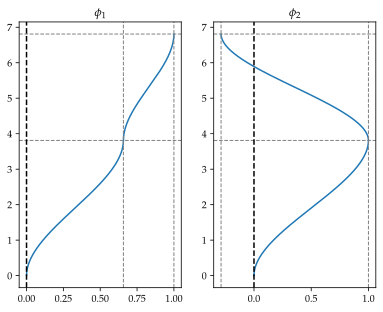

In [13]:
#| label: fig-eigenvektoren
#| fig-cap: "Deformation des Mehrmassenschwingers anhand der Eigenvektoren"



#Numerische Daten generieren
w_eigenform_1_lamb = sp.lambdify(x, w_eigenform_1.rhs)
w_eigenform_2_lamb = sp.lambdify(x, w_eigenform_2.rhs)

x_array = np.linspace(0, float((H_1+H_2).subs(params_plot)), 1000)

w_1_array = w_eigenform_1_lamb(x_array)
w_2_array = w_eigenform_2_lamb(x_array)


# Figure und Axes erstellen
fig, (ax1, ax2) = plt.subplots(1, 2)

# Ersten Plot erstellen

ax1.plot(w_1_array, x_array)
ax1.set_title('$\phi_1$')

## Horizontale Linien
ax1.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax1.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax1.axvline(phi_21.subs(params),linestyle='dashed', color='gray',linewidth=1)
ax1.axvline(phi_11.subs(params),linestyle='dashed', color='gray',linewidth=1)

ax1.axvline(0,linestyle='dashed', color='black')




# Zweiten Plot erstellen

ax2.plot(w_2_array, x_array)
ax2.set_title('$\phi_2$')

## Horizontale Linien
ax2.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax2.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax2.axvline(phi_22.subs(params),linestyle='dashed', color='gray',linewidth=1)
ax2.axvline(phi_12.subs(params),linestyle='dashed', color='gray',linewidth=1)

ax2.axvline(0,linestyle='dashed', color='black')


# Plots anzeigen
plt.show()




### Modale Analyse

Die Modale Analyse zielt darauf ab, den Zweimassenschwinger zu entkoppeln. Dazu wird in einem ersten Schritt die Orthogonalitätsbedingung kontrolliert. Diese muss erfüllt sein um eine Entkoppelung durchzuführen.

#### Orthogonalitätsbedingung

Angewendet auf die Massenmatrix:
Es zeigen sich kleine numerische Unreinheiten, welche vernachlässigt werden können.

In [14]:
render.eq_display(sp.MatrixSymbol('phi_1',2,1).T*sp.MatrixSymbol('M', 2,2)*sp.MatrixSymbol('phi_1',2,1),(phi_1.T*M*phi_1).subs(params).evalf(3),
                  
                  sp.MatrixSymbol('phi_2',2,1).T*sp.MatrixSymbol('M', 2,2)*sp.MatrixSymbol('phi_2',2,1),(phi_2.T*M*phi_2).subs(params).evalf(3),

                  sp.MatrixSymbol('phi_2',2,1).T*sp.MatrixSymbol('M', 2,2)*sp.MatrixSymbol('phi_1',2,1),(phi_2.T*M*phi_1).subs(params).evalf(3),

                  sp.MatrixSymbol('phi_1',2,1).T*sp.MatrixSymbol('M', 2,2)*sp.MatrixSymbol('phi_2',2,1),(phi_1.T*M*phi_2).subs(params).evalf(3))

           ⎡                     2⎤
  T        ⎢5.71e+3⋅newton⋅second ⎥
φ₁ ⋅M⋅φ₁ = ⎢──────────────────────⎥
           ⎣        meter         ⎦

           ⎡                    2⎤
  T        ⎢2.5e+3⋅newton⋅second ⎥
φ₂ ⋅M⋅φ₂ = ⎢─────────────────────⎥
           ⎣        meter        ⎦

           ⎡                      2⎤
  T        ⎢1.59e-12⋅newton⋅second ⎥
φ₂ ⋅M⋅φ₁ = ⎢───────────────────────⎥
           ⎣         meter         ⎦

           ⎡                      2⎤
  T        ⎢1.59e-12⋅newton⋅second ⎥
φ₁ ⋅M⋅φ₂ = ⎢───────────────────────⎥
           ⎣         meter         ⎦

Für die Steifigkeitsmatrix:

In [15]:
render.eq_display(sp.MatrixSymbol('phi_1',2,1).T*sp.MatrixSymbol('K', 2,2)*sp.MatrixSymbol('phi_1',2,1),sp.simplify((phi_1.T*K*phi_1).subs(params)).evalf(3),
                  
                  sp.MatrixSymbol('phi_2',2,1).T*sp.MatrixSymbol('K', 2,2)*sp.MatrixSymbol('phi_2',2,1),sp.simplify((phi_2.T*K*phi_2).subs(params)).evalf(3),

                  sp.MatrixSymbol('phi_2',2,1).T*sp.MatrixSymbol('K', 2,2)*sp.MatrixSymbol('phi_1',2,1),sp.simplify((phi_2.T*K*phi_1).subs(params)).evalf(4),
                  
                  sp.MatrixSymbol('phi_1',2,1).T*sp.MatrixSymbol('K', 2,2)*sp.MatrixSymbol('phi_2',2,1),sp.simplify((phi_1.T*K*phi_2).subs(params)).evalf(4))

  T        ⎡1.45e+5⋅newton⎤
φ₁ ⋅K⋅φ₁ = ⎢──────────────⎥
           ⎣    meter     ⎦

  T        ⎡8.28e+5⋅newton⎤
φ₂ ⋅K⋅φ₂ = ⎢──────────────⎥
           ⎣    meter     ⎦

  T        ⎡9.459e-11⋅newton⎤
φ₂ ⋅K⋅φ₁ = ⎢────────────────⎥
           ⎣     meter      ⎦

  T        ⎡9.459e-11⋅newton⎤
φ₁ ⋅K⋅φ₂ = ⎢────────────────⎥
           ⎣     meter      ⎦

#### Modal- und Spektralmatrix

Mittels der Modal- und Spektralmatrix lassen sich die generalisierten Grössen effizient ermitteln.

In [16]:
Phi = sp.Matrix([[phi_1, phi_2]])
Omega = sp.Matrix([[omega_1, 0],[0, omega_2]])

render.eq_display('Modalmatrix', 'Phi',
                  sp.MatrixSymbol('Phi', 2, 2), Phi.subs(params).evalf(4),
                  'Spektralmatrix', 'Omega^2',
                  sp.MatrixSymbol('Omega^2', 2, 2), (Omega**2).subs(params).evalf(4))

Modalmatrix = Φ

    ⎡0.6573    1.0  ⎤
Φ = ⎢               ⎥
    ⎣ 1.0    -0.2876⎦

                  2
Spektralmatrix = Ω 

     ⎡ 25.38          ⎤
     ⎢───────     0   ⎥
     ⎢      2         ⎥
     ⎢second          ⎥
Ω² = ⎢                ⎥
     ⎢          331.7 ⎥
     ⎢   0     ───────⎥
     ⎢               2⎥
     ⎣         second ⎦

#### Generalisierte Grössen

In [17]:
M_star = Phi.T * M * Phi
K_star = Phi.T * K * Phi


render.eq_display(sp.MatrixSymbol('M^\star', 2,2),sp.simplify(M_star.subs(params)).evalf(5),
                  sp.MatrixSymbol('K^\star', 2,2),sp.simplify(K_star.subs(params)).evalf(5))
                 

           ⎡                      2                            2⎤
           ⎢  5707.3⋅newton⋅second     1.5916e-12⋅newton⋅second ⎥
           ⎢  ─────────────────────    ─────────────────────────⎥
           ⎢          meter                      meter          ⎥
M__\star = ⎢                                                    ⎥
           ⎢                        2                        2  ⎥
           ⎢1.5916e-12⋅newton⋅second     2497.0⋅newton⋅second   ⎥
           ⎢─────────────────────────    ─────────────────────  ⎥
           ⎣          meter                      meter          ⎦

           ⎡1.4487e+5⋅newton   9.4587e-11⋅newton⎤
           ⎢────────────────   ─────────────────⎥
           ⎢     meter               meter      ⎥
K__\star = ⎢                                    ⎥
           ⎢9.4587e-11⋅newton  8.2813e+5⋅newton ⎥
           ⎢─────────────────  ──────────────── ⎥
           ⎣      meter             meter       ⎦

#### Kontrolle der modalen Transformation

Die Eigenkreisfrequenzen ändern sich durch die Transformation nicht.

In [18]:
omega_1_kontrolle = sp.sqrt(K_star[0] / M_star[0])
omega_2_kontrolle = sp.sqrt(K_star[3] / M_star[3])

render.eq_display('omega_1', omega_1.subs(params).simplify().evalf(3),
                  'omega_1_modal', omega_1_kontrolle.subs(params).simplify().evalf(3),
                  'omega_2', omega_2.subs(params).simplify().evalf(4),
                  'omega_2_modal', omega_2_kontrolle.subs(params).simplify().evalf(4))




      5.04 
ω₁ = ──────
     second

             5.04 
ω_1_modal = ──────
            second

     18.21 
ω₂ = ──────
     second

            18.21 
ω_2_modal = ──────
            second

#### Partizipationsfaktor $\Gamma$

Die Verteilung des Partizipationsfaktor gibt einen direkten Hinweis, welcher Eigenmode an der Gesamtanwort den grössten Einfluss (beteiligt bzw. partizipiert) hat.

$$\Gamma_n = \frac{\Phi_n^T \mathbf{M 1}}{\Phi_n^T \mathbf{M}\Phi_n}$$

In allgemeiner Form lautet der Partizipationsfaktor:

$$
\Gamma_n = \frac{\Phi_n^T \mathbf{M r^\star}}{\Phi_n^T \mathbf{M}\Phi_n}
$${#eq-split_part}

$\mathbf{r^\star}$ beschreibt die Starrkörperverschiebung infolge der Erdbebenanregung $u_g$ am Fusspunkt des Gesamtsystems.



$$\mathbf{r^\star} = \begin{bmatrix}
FHG_1 \\
FHG_2 
\end{bmatrix}=
\begin{bmatrix}
\cos(0) \\
\cos(0) 
\end{bmatrix}=
\begin{bmatrix}
1 \\
1 
\end{bmatrix}= \mathbf{1}$$

Die Partizipationsmatrix lässt sich direkt durch folgende Gleichung ermitteln:

$$
\Gamma = M^{\star-1} \cdot \Phi^T \cdot M \cdot 1
$${#eq-matrix_part}

Gelöst mit @eq-matrix_part:

In [19]:
Gamma = M_star**-1 * Phi.T * M*one_vec 

render.eq_display(
    sp.MatrixSymbol('Gamma',2,1), Gamma.subs(params).evalf(3))

NameError: name 'one_vec' is not defined

Gelöst mit @eq-split_part:

In [ ]:
one_vec = sp.ones(2,1)

gamma_1 = (phi_1.T*M*one_vec)[0]/(phi_1.T*M*phi_1)[0]
gamma_2 = (phi_2.T*M*one_vec)[0]/(phi_2.T*M*phi_2)[0]
gamma_sqr = sp.Matrix([[gamma_1**2],[gamma_2**2]])
render.eq_display('Gamma_1', gamma_1,
                  'Gamma_1', gamma_1.subs(params).evalf(3),
                  'Gamma_2', gamma_2,
                  'Gamma_2', gamma_2.subs(params).evalf(3),
                  sp.MatrixSymbol('Gamma^2_n',2,1),gamma_sqr.subs(params).evalf(3))

      m₁⋅φ₁₁ + m₂⋅φ₂₁ 
Γ₁ = ─────────────────
           2         2
     m₁⋅φ₁₁  + m₂⋅φ₂₁ 

Γ₁ = 1.08

      m₁⋅φ₁₂ + m₂⋅φ₂₂ 
Γ₂ = ─────────────────
           2         2
     m₁⋅φ₁₂  + m₂⋅φ₂₂ 

Γ₂ = 0.288

      ⎡ 1.17 ⎤
Γ²ₙ = ⎢      ⎥
      ⎣0.0831⎦

### Elastisches Antwortspektrum

Aus der Aufgabenstellung darf nach [@SIA261_2020] Abs. 16.2.3.1 Kurve $E$ gewählt werden.

In [ ]:
a_gd = 1 *unit.m /unit.second**2

#### Grundschwingzeit

Die Grundschwingzeit kann anhand der bereits ermittelten Eigenkreisfrequenzen ermittelt werden.

In [ ]:
T_1 = (omega_1 /(2*sp.pi))**-1
T_2 = (omega_2 /(2*sp.pi))**-1

render.eq_display('T_1', T_1.subs(params).evalf(3),
                  'T_2', T_2.subs(params).evalf(3),
                  )

T₁ = 1.25⋅second

T₂ = 0.345⋅second

#### Elastisches Antwortspektrum

In [ ]:

S_e_1 = antwortspektrum(a_gd, T_1.subs(params).evalf(3), Baugrundklasse='E')
render.eq_display('S_e_1', S_e_1.evalf(3))

     2.5⋅S⋅T_C⋅a_gd⋅η
Sₑ = ────────────────
            T        

       0.852⋅meter
Sₑ ₁ = ───────────
               2  
         second   

In [ ]:
S_e_2 = antwortspektrum(a_gd, T_2.subs(params).evalf(3), Baugrundklasse = 'E')

render.eq_display('S_e_2', S_e_2.evalf(3))

     2.5⋅S⋅T_C⋅a_gd⋅η
Sₑ = ────────────────
            T        

       3.08⋅meter
Sₑ ₂ = ──────────
              2  
        second   

### Maximale Deformation

Die maximale Deformation resultiert aus der Beschleunigung $S_e$ und der Eigenkreisfrequenz $\omega_n^2$. Für die Modalen EMS gilt es diese anhand der Partizipationsfaktoren zu gewichten. Zur effektiven Bestimmung der Auslenkung sind die Resultate der EMS mittels SRSS-Regel zu überlagern.

In [ ]:
q_1_max = Gamma[0] * S_e_1 / omega_1**2
q_2_max = Gamma[1] * S_e_2 / omega_2**2

render.eq_display('q_1_max',"Gamma_1 * S_e_1 / omega_1**2",
'q_1_max', q_1_max.subs(params).evalf(3),
'q_2_max',"Gamma_2 * S_e_2 / omega_2**2",
'q_2_max', q_2_max.subs(params).evalf(3))


         Γ₁⋅Sₑ ₁
q₁ ₘₐₓ = ───────
             2  
           ω₁   

q₁ ₘₐₓ = 0.0364⋅meter

         Γ₂⋅Sₑ ₂
q₂ ₘₐₓ = ───────
             2  
           ω₂   

q₂ ₘₐₓ = 0.00268⋅meter

Um die Entkoppelung rückzuführen gilt es die erhaltenen Resultate zu überlagern. Dabei gibt es unterschiedliche Ansätze. Bei weit auseinander liegenden Eigenfrequenzen kann die SRSS-Überlagerung verwendet werden.

$$u_{max} = \sqrt{\sum_{n=1}^2 (q_{n} \cdot \phi_n)^2}$$

In [ ]:
u_max = ((phi_1*q_1_max).applyfunc(lambda x: x**2)+(phi_2*q_2_max).applyfunc(lambda x: x**2)).applyfunc(sp.sqrt)


render.eq_display(sp.MatrixSymbol('u_max', 2,1), u_max.subs(params).evalf(3))

       ⎡0.024⋅meter ⎤
uₘₐₓ = ⎢            ⎥
       ⎣0.0364⋅meter⎦

In [ ]:
Delta_A, Delta_B, zeta = sp.symbols('Delta_A, Delta_B, zeta')



#Ansatzfunktion für Teil 1 der Funktion
zeta = x/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)

w_1_x = w_ansatz.subs(Delta_A, 0).subs(Delta_B, u_max[0].subs(params)/unit.m).subs(l,H_1.subs(params_plot))




#Ansatzfunktion für Teil 2 der Funktion
zeta = (x-H_1.subs(params_plot))/l
w_ansatz = Delta_A + (Delta_B-Delta_A)*(3*zeta**2 - 2*zeta**3)

w_2_x = w_ansatz.subs(Delta_A, u_max[0].subs(params)/unit.m).subs(Delta_B, u_max[1].subs(params)/unit.m).subs(l,H_2.subs(params_plot))



#Zusammengestellt
w_eigenform_1 = sp.Eq(w,sp.Piecewise((w_1_x, x<=H_1.subs(params_plot)),(w_2_x, x>=H_1.subs(params_plot))))


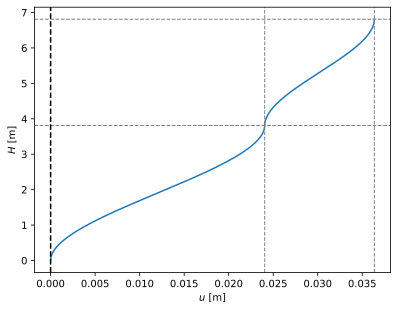

In [ ]:
#| label: fig-deformation
#| fig-cap: "Maximale Deformation des Mehrmassenschwingers"



#Numerische Daten generieren
w_eigenform_1_lamb = sp.lambdify(x, w_eigenform_1.rhs)

x_array = np.linspace(0, float((H_1+H_2).subs(params_plot)), 1000)

w_1_array = w_eigenform_1_lamb(x_array)



# Ersten Plot erstellen

plt.plot(w_1_array, x_array)

## Horizontale Linien
plt.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
plt.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

plt.axvline(u_max[1].subs(params)/unit.m,linestyle='dashed', color='gray',linewidth=1)
plt.axvline(u_max[0].subs(params)/unit.m,linestyle='dashed', color='gray',linewidth=1)

plt.axvline(0,linestyle='dashed', color='black')
plt.xlabel('$u$ [m]')
plt.ylabel('$H$ [m]')


# Plots anzeigen
plt.show()




### Maximale Schnittkräfte

#### Querkräfte

Die Einwirkungen resultieren aus der Masse multipliziert mit der Beschleunigung aus dem Antwortspektrum. Dazu sind in einem ersten Schritt die beiden entkoppelten EMS von einander getrennt zu betrachten. Die Überlagerung erfolgt erst bei den ermittelten Querkräften.

$$
M_1 = \Gamma \cdot M \cdot \phi_1
$$

$$
F_{1max} = M_1 \cdot S_{e1}
$$

Aus dem ersten EMS folgt:

In [ ]:
M_1 = Gamma[0] * M * phi_1
F_1_max = M_1* S_e_1
V_1 = sp.Matrix([[F_1_max[0]+F_1_max[1]],[F_1_max[1]]])

render.eq_display(sp.MatrixSymbol('M_1', 2,1), m_1.subs(params).evalf(5),
                  sp.MatrixSymbol('F_1_max', 2,1), F_1_max.subs(params).evalf(5),
                  sp.MatrixSymbol('V_1', 2,1), V_1.subs(params).evalf(5))

False

         ⎡1273.7⋅newton⎤
F₁ ₘₐₓ = ⎢             ⎥
         ⎣4429.2⋅newton⎦

     ⎡5702.9⋅newton⎤
V₁ = ⎢             ⎥
     ⎣4429.2⋅newton⎦

Aus dem zweiten EMS folglich:

In [ ]:
M_2 = Gamma[1] * M * phi_2
F_2_max = M_2* S_e_2
V_2 = sp.Matrix([[F_2_max[0]+F_2_max[1]],[F_2_max[1]]])

render.eq_display(sp.MatrixSymbol('M_2', 2,1), M_2.subs(params).evalf(5),
                  sp.MatrixSymbol('F_2_max', 2,1), F_2_max.subs(params).evalf(5),
                  sp.MatrixSymbol('V_2', 2,1), V_2.subs(params).evalf(5))


     ⎡                     2 ⎤
     ⎢ 605.23⋅newton⋅second  ⎥
     ⎢ ───────────────────── ⎥
     ⎢         meter         ⎥
M₂ = ⎢                       ⎥
     ⎢                     2 ⎥
     ⎢-397.83⋅newton⋅second  ⎥
     ⎢───────────────────────⎥
     ⎣         meter         ⎦

         ⎡1864.2⋅newton ⎤
F₂ ₘₐₓ = ⎢              ⎥
         ⎣-1225.4⋅newton⎦

     ⎡638.82⋅newton ⎤
V₂ = ⎢              ⎥
     ⎣-1225.4⋅newton⎦

Maximale Querkraft aus Überlagerung beider EMS mittels SRSS-Regel.

$$
V_{max} = \sqrt{V_1^2 + V_2^2}
$$

In [ ]:
V_max = (V_1.applyfunc(lambda x: x**2)+V_2.applyfunc(lambda x: x**2)).applyfunc(sp.sqrt)


render.eq_display(sp.MatrixSymbol('V_max', 2,1), V_max.subs(params).evalf(3))

       ⎡5.74e+3⋅newton⎤
Vₘₐₓ = ⎢              ⎥
       ⎣4.6e+3⋅newton ⎦

#### Biegemomente

Die Biegemomente lassen sich abschliessend anhand der Querkräfte bestimmen.

#### Normalkräfte

Die Normalkräfte resultieren aus den Punktmassen.

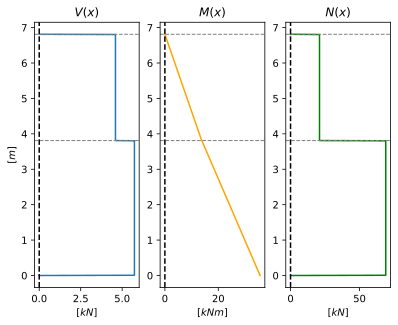

In [ ]:
#| label: fig-schnittgroessen
#| fig-cap: "Maximale Schnittgrössen"

# Querkraft
V_x = sp.Piecewise((V_max[0].subs(params)/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))), (V_max[1].subs(params)/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))), (0,True))

# Biegemoment
C_1 = sp.symbols('C_1')
M_x = sp.integrate(-V_x, x) + C_1
C_1_solve = sp.solve(M_x.subs(x, (H_1+H_2).subs(params_plot)), C_1)[0]
M_x = M_x.subs(C_1, C_1_solve)

# Normalkraft
g = 10*unit.m/unit.second**2
N_x = sp.Piecewise(((m_1+m_2).subs(params)*g/unit.N, ((x>0)&(x<=H_1.subs(params_plot)))),(m_1.subs(params)*g/unit.N, ((x>=H_1.subs(params_plot))&(x<=(H_1+H_2).subs(params_plot)))), (0,True))



# Numerische Daten generieren
V_x_lamb = sp.lambdify(x, V_x)
V_x_array = V_x_lamb(x_array)

M_x_lamb = sp.lambdify(x,M_x)
M_x_array = M_x_lamb(x_array)

N_x_lamb = sp.lambdify(x,N_x)
N_x_array = N_x_lamb(x_array)

# Figure und Axes erstellen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Ersten Plot erstellen

ax1.plot(V_x_array/1000, x_array)
ax1.set_title('$V(x)$')

## Horizontale Linien
ax1.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax1.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax1.set_xlabel('$[kN]$')
ax1.set_ylabel('$[m]$')

ax1.axvline(0,linestyle='dashed', color='black')


# Zweiten Plot erstellen

ax2.plot(M_x_array/1000, x_array, color='orange')
ax2.set_title('$M(x)$')

## Horizontale Linien
ax2.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax2.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)

ax2.set_xlabel('$[kNm]$')

ax2.axvline(0,linestyle='dashed', color='black')


# Dritten Plot erstellen

ax3.plot(N_x_array/1000, x_array, color='green')
ax3.set_title('$N(x)$')
ax3.set_xlabel('$[kN]$')


## Horizontale Linien
ax3.axhline(H_1.subs(params_plot),linestyle='dashed', color='gray',linewidth=1)
ax3.axhline((H_1+H_2).subs(params_plot),linestyle='dashed', color='gray',linewidth=1)


ax3.axvline(0,linestyle='dashed', color='black')



# Plots anzeigen
plt.show()


